# MQTT-SN between FIT and Grid'5000

Revisiting https://www.iot-lab.info/learn/tutorials/riot/riot-mqtt-sn-a8-m3/  in the context of mixed G5K/FIT resources.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib
---


## Prerequisites:

<div class="alert alert-block alert-warning">
    Make sure you've run the one time setup for your environment (e.g one time setup for https://labs.iot-lab.info)
</div>
Also make sure that the mqttsn client firmware can be compiled with a custom channel (not necessary if riot source are up-to-date)

## Overview


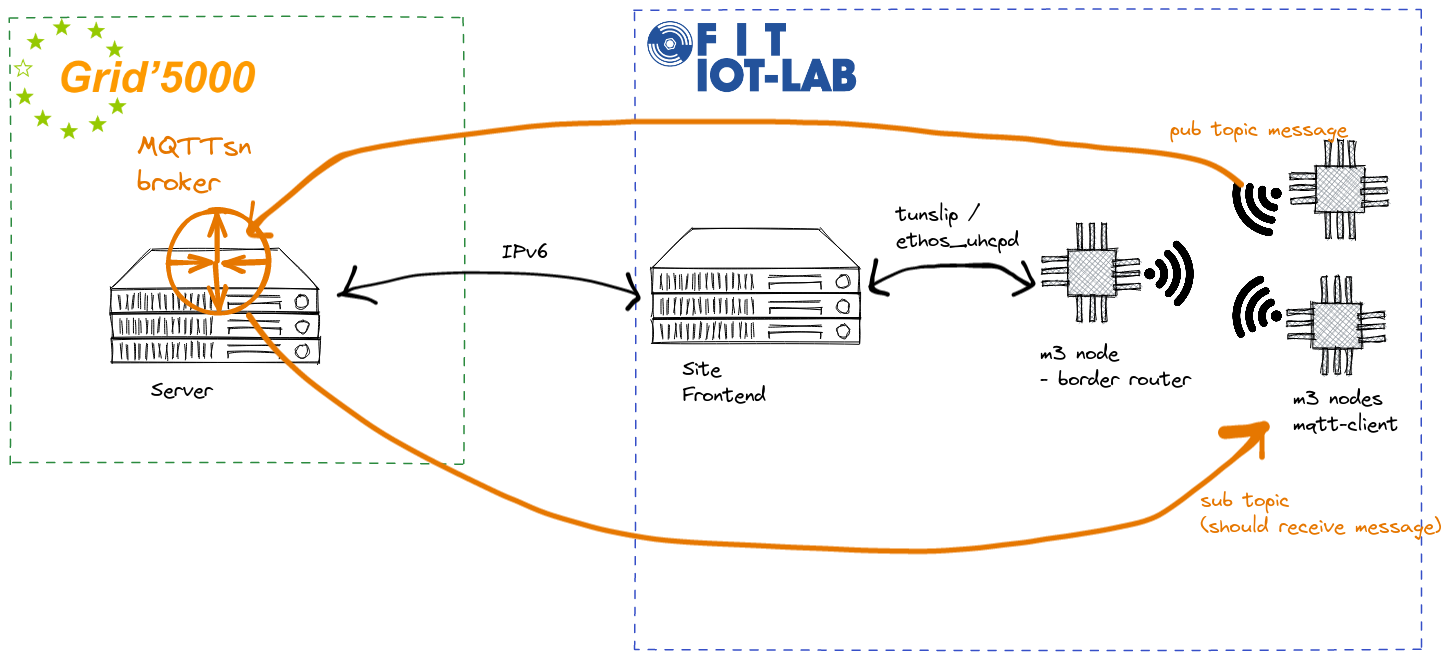

## FIT side

### Firmware compilations

In [ ]:
import os,binascii,random
pan_id = binascii.b2a_hex(os.urandom(2)).decode()
channel = random.randint(11, 26)
fit_site = random.choice(["grenoble", "lille"])

print(f"Use FIT_SITE={fit_site}, CHANNEL={channel}, PAN_ID=0x{pan_id}")

In [ ]:
# save the random parameters (allow to restart from here) 
FIT_SITE = "lille"
%env CHANNEL = 21
%env PAN_ID = 0x20ce
%env ETHOS_BAUDRATE = 500000

In [ ]:
%env APP_DIR=../../riot/RIOT/examples/gnrc_border_router
!make -C $APP_DIR BOARD=iotlab-m3 DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/*.bin .

---
We need to set a different EMCUTE_ID to our mqtt clients. 
So we're compiling twice the firmware to differenciate our clients.

In [ ]:
%env APP_DIR=../../riot/RIOT/examples/emcute_mqttsn
!make -C $APP_DIR BOARD=iotlab-m3 EMCUTE_ID="plop" DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/emcute_mqttsn.bin emcute_mqttsn_plop.bin
!make -C $APP_DIR BOARD=iotlab-m3 EMCUTE_ID="plip" DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/emcute_mqttsn.bin emcute_mqttsn_plip.bin

### Get some resources

In [ ]:
import enoslib as en

en.init_logging()

In [ ]:
fit_conf = (
    en.IotlabConf.from_settings(job_name="riot_m3", walltime="02:00")
    .add_machine(roles=["border_router"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="gnrc_border_router.bin")   
    .add_machine(roles=["other"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="emcute_mqttsn_plop.bin")
    .add_machine(roles=["other"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="emcute_mqttsn_plip.bin")
).finalize()
fit_conf


# Hostname based
# fit_conf = (
#   en.IotlabConf.from_settings(job_name="riot_m3", walltime="02:00")
#   .add_machine(roles=["border_router"], hostname=["m3-279.grenoble.iot-lab.info"], image="gnrc_border_router.bin")   
#   .add_machine(roles=["other"], hostname=["m3-280.grenoble.iot-lab.info"], image="emcute_mqttsn_plop.bin")
#   .add_machine(roles=["other"], hostname=["m3-281.grenoble.iot-lab.info"], image="emcute_mqttsn_plip.bin")
# ).finalize()
# fit_conf

In [ ]:
network = en.G5kNetworkConf(type="prod", roles=["my_network"], site="nancy")

conf = (
    en.G5kConf.from_settings(job_type="allow_classic_ssh", job_name="mqtt")
    .add_network_conf(network)
    .add_machine(
        roles=["broker"], cluster="grisou", nodes=1, primary_network=network
    )
    .finalize()
)
conf

In [ ]:
fit = en.Iotlab(fit_conf, name= "Iotlab")
g5k = en.G5k(conf,name= "G5k")

In [ ]:
# Here we set up a special provider that will try to reserve both G5k and Iotlab configuration simultaneously

from enoslib.infra.providers import Providers


providers = Providers([fit, g5k])

In [ ]:
roles, networks = providers.init(86400)
fit, g5k = providers.providers

In [ ]:
# keep track of the border router
br = roles["border_router"][0]
br

In [ ]:
# useless at this point, but practical if you need to reset your nodes
fit.reset()

### Setting up IPv6

In [ ]:
import iotlabcli
iotlab_user, _ = iotlabcli.auth.get_user_credentials()
fit_frontend = en.Host("%s.iot-lab.info" % FIT_SITE, user=iotlab_user) 

At this point you need to pick a free tap number and a [free subnet](https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html)  

In [ ]:
r = en.run(f"ip -6 route", roles=fit_frontend)
print(r[0].stdout)

In [ ]:
# CHANGE ME!
tap = "tap2"
prefix = "2001:660:4403:0481"

In [ ]:
en.run(f"ps aux | grep {tap} | grep {iotlab_user}| grep -v grep | awk '{{print $2}}' | xargs -r kill", roles=fit_frontend)

In [ ]:
r = en.run(f"sudo ethos_uhcpd.py {br.alias} {tap} {prefix}::1/64 2>&1 >> ethos_uhcpd.out", roles=fit_frontend, background=True)

In [ ]:
r = en.run(f"ip -6 route", roles=fit_frontend)
print(r[0].stdout)

The other M3 device should get its IPv6 in the chosen after few seconds.
Retry the following until you get this IPv6 (or until you get bored)

Note that the command sends a command (`ifconfig`) to the other M3 device after SSH-ing to the frontend.

In [ ]:
import re

mqtt_nodes = []
for other in roles["other"]:
    r = en.run(f"echo ifconfig | nc -w1  {other.alias} 20000", fit_frontend)
    print(r[0].stdout)
    m = re.findall(f'inet6 addr: (.*)  scope: global', r[0].stdout)
    if m:
        mqtt_nodes.append(m[0])
mqtt_nodes

In [ ]:
for other in roles["other"]:
    # connectivity test with ... google
    r = en.run(f"echo ping6 2001:4860:4860::8888 | nc -w5  {other.alias} 20000", fit_frontend)
    print(r[0].stdout)

## Grid'5000 side

### Get some resources

You can check what's available here: https://www.grid5000.fr/w/Status

Some direct links:
- Gantt for nancy: https://intranet.grid5000.fr/oar/Nancy/drawgantt-svg/
- Gantt for rennes: https://intranet.grid5000.fr/oar/Rennes/drawgantt-svg/
- ...


### Setting up IPv6

In [ ]:
en.run_command("dhclient -6 br0", roles=roles["G5k"])
# we open the firewall (not idempotent)


r = en.run_command("ip a", roles=roles["G5k"])
print(r[0].stdout)

In [ ]:
g5k.fw_create(proto="all")

### Broker deployment (on G5k)

In [ ]:
with en.actions(roles=roles["G5k"]) as a:
    broker_sources_dir = "/tmp/broker" 
    mqttsn_sources_dir = f"{broker_sources_dir}/rsmb/src"
    a.git(repo="https://github.com/eclipse/mosquitto.rsmb", dest=broker_sources_dir)
    a.shell("make", chdir=mqttsn_sources_dir)
    a.copy(src="broker.conf", dest=f"{mqttsn_sources_dir}/broker.conf")
    a.shell("./broker_mqtts broker.conf 2>&1 | tee /tmp/broker.out", chdir=mqttsn_sources_dir, background=True)

## Publish some messages

- (TERMINAL 1) Connect to the broker log on g5k: `tail -f /tmp/broker.out` on the G5K node of the reservation
- (TERMINAL 2) Connect to the first m3 node from the FIT frontend: `nc m3-XXX 20000` then use `con G5K_IPV6 1885` (replace G5K_IPv6 by the right IPv6)
- (TERMINAL 3) Connect to the other m3 node from the FIT frontend: `nc m3-YYYY 20000` then use `con G5K_IPV6 1885` (replace G5K_IPv6 by the right IPv6)
- (TERMINAL 2) Subscribe to a topic `sub test`
- (TERMINAL 3) Publish to the same topic `pub test toto`
- (TERMINAL 2) The message should have arrived !

In [ ]:
# for the record
roles["G5k"]

In [ ]:
roles["Iotlab"]

## Clean up

In [ ]:
providers.destroy()